In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-72eca64b-fe7c-5245-8a24-d5fbad11bd01)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/Detectron/

In [ ]:
!zip -r '/content/drive/MyDrive/Detectron.zip' '/content/drive/MyDrive/Detectron'

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

### Some basic setup, import:

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
import glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

Set seed for reproducibility

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(seed=SEED)
torch.manual_seed(SEED)

# Run a pre-trained detectron2 model

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset


## Prepare the dataset

In [ ]:
# dataset_name = "my_dataset_train"
# metadata = {}
# json_file = "path_to_.json"
# image_root = "path_to_image_root"

In [ ]:
dataset_name = "glass1"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glass1/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glass1"

In [ ]:
val_dataset_name = "val_glass1"
val_metadata = {}
val_json_file = "/content/drive/MyDrive/Detectron/data/valid20/result.json"
val_image_root = "/content/drive/MyDrive/Detectron/data/valid20"

In [ ]:
register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
register_coco_instances(val_dataset_name, val_metadata, val_json_file, val_image_root)
val_metadata = MetadataCatalog.get(val_dataset_name)
val_dataset_dicts = DatasetCatalog.get(val_dataset_name)

In [ ]:
def random_sample(dataset_dicts, number, metadata):
    for d in random.sample(dataset_dicts, number):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        cv2_imshow(vis.get_image()[:, :, ::-1])

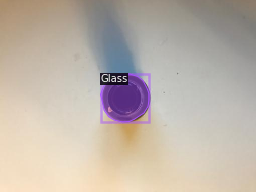

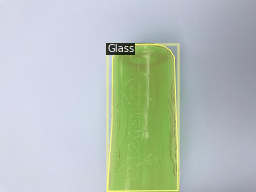

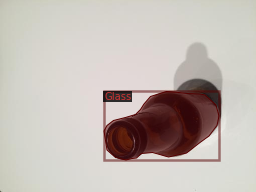

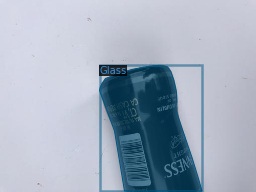

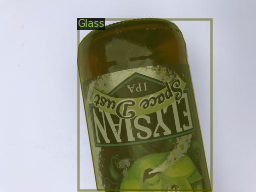

In [ ]:
random_sample(dataset_dicts, 5, metadata)

## Train

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the dataset.


In [ ]:
def train(dataset_name, 
          images_per_batch=2, 
          learning_rate=0.00025, 
          iteration=300, 
          batch_size_per_image=512, 
          num_classes=1, 
          test=False, 
          test_dataset_name="",
          init_model="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"):
    
    cfg = get_cfg()

    # cfg.MODEL.DEVICE='cpu'

    cfg.merge_from_file(model_zoo.get_config_file(init_model))
    cfg.DATASETS.TRAIN = (dataset_name,)

    if test:
        cfg.DATASETS.TEST = (test_dataset_name,)
    else:
        cfg.DATASETS.TEST = ()

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(init_model)  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = images_per_batch  # This is the real "batch size" commonly known to deep learning people (number of images per batch)
    cfg.SOLVER.BASE_LR = learning_rate  
    cfg.SOLVER.MAX_ITER = iteration
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size_per_image   # The "RoIHead batch size". 128 is faster, (default: 512). Number of regions per image used to train RPN.
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    if test:
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        predictor = DefaultPredictor(cfg)
        evaluator = COCOEvaluator(test_dataset_name, output_dir="./output")
        test_result = trainer.test(cfg, predictor.model, evaluator)
        return cfg, test_result

    return cfg, ""

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=1, 
                         test=True, 
                         test_dataset_name=val_dataset_name)

In [ ]:
df = pd.DataFrame(test_result, columns=test_result.keys())

In [ ]:
df

,bbox,segm
AP,10.338533,11.135070
AP50,12.723263,12.723263
AP75,12.171743,12.723263
APs,NaN,NaN
APm,0.000000,0.000000
APl,10.338533,11.135070
AP-Glass,41.354132,44.540279
AP-Metal,0.000000,0.000000
AP-Paper,0.000000,0.000000
AP-Plastic,0.000000,0.000000


## Inference & evaluation using the trained model
Let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("val_glass1", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val_glass1")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
def evaluate(image, metadata, instance_mode=False):
    im = cv2.imread(image)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    v = {}
    if instance_mode:
        v = Visualizer(im[:, :, ::-1],
                        metadata=metadata, 
                        scale=0.5, 
                        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
    else:
        v = Visualizer(im[:, :, ::-1],
                        metadata=metadata, 
                        scale=0.5,
        )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

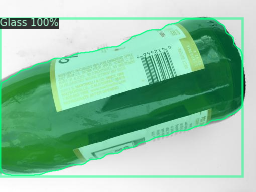

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass451.jpg", metadata, instance_mode=True)

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass451.jpg", metadata, instance_mode=False)

In [ ]:
def random_test_sample(dataset_dicts, number, metadata, instance_mode=False):
    for i in range(number):
        images = glob.glob(dataset_dicts + "*.jpg")
        random_image = random.choice(images)
        evaluate(random_image, metadata, instance_mode)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/"
random_test_sample(test_dataset_path, 5, metadata)

## Automation of training, parameter setting

In [ ]:
# images_per_batch = [2, 4, 8, 16, 32, 64]
# learning_rate = [0.01, 0.0025, 0.001, 0.00025, 0.0001, 0.000025, 0.00001]
# batch_size_per_image = [128, 256, 512] 
# iteration = 300
# num_classes = 4

In [ ]:
# result = []
# for ipb in images_per_batch:
#     for lr in learning_rate:
#         for bspi in batch_size_per_image:
#             cfg, test_result = train(dataset_name, 
#                                      images_per_batch=ipb, 
#                                      learning_rate=lr, 
#                                      iteration=iteration, 
#                                      batch_size_per_image=bspi, 
#                                      num_classes=num_classes, 
#                                      test=True, 
#                                      test_dataset_name=val_dataset_name)

#             result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
# df = pd.DataFrame()
# for i in range(len(result)):
#     temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
#     temp = temp.T

#     images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
#     learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
#     batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

#     temp['images_per_batch'] = images_per_batch.values
#     temp['learning_rate'] = learning_rate.values
#     temp['batch_size_per_image'] = batch_size_per_image.values

#     df = pd.concat([df, temp])

In [ ]:
# df

## Train with more data

### Train2

In [ ]:
dataset_name = "glassAndMetal2"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassAndMetal2/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassAndMetal2"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=2, 
                         test=False, 
                         test_dataset_name=val_dataset_name)

### Evaluate2

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

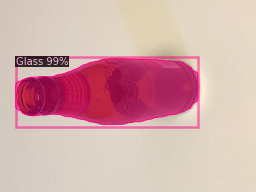

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

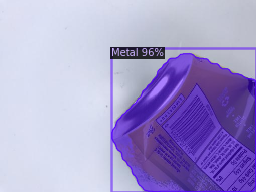

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/"
random_test_sample(test_dataset_path, 3, metadata)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/"
random_test_sample(test_dataset_path, 3, metadata)

### Train3

In [ ]:
dataset_name = "glassAndMetal4"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassAndMetal4/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassAndMetal4"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=2, 
                         test=False, 
                         test_dataset_name=val_dataset_name)

### Evaluate3

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

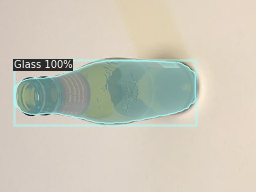

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

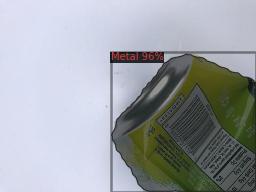

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/"
random_test_sample(test_dataset_path, 3, metadata)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/"
random_test_sample(test_dataset_path, 3, metadata)

### Train4

In [ ]:
dataset_name = "glassAndMetal7"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassAndMetal7/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassAndMetal7"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=2, 
                         test=False, 
                         test_dataset_name=val_dataset_name)

### Evaluate4

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

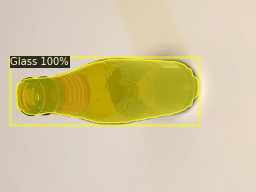

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

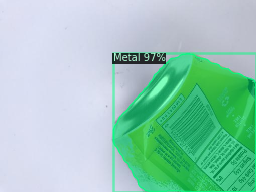

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/"
random_test_sample(test_dataset_path, 3, metadata)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/"
random_test_sample(test_dataset_path, 3, metadata)

### Train5

In [ ]:
dataset_name = "glassAndMetalAndPlastic8"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassAndMetalAndPlastic8/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassAndMetalAndPlastic8"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=3, 
                         test=False, 
                         test_dataset_name=val_dataset_name)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

### Evaluate5

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

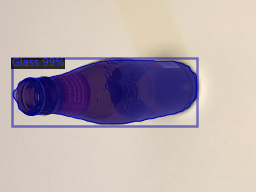

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

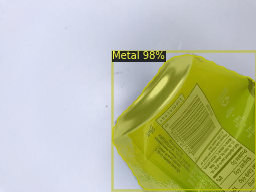

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/plastic/test/plastic433.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/"
random_test_sample(test_dataset_path, 3, metadata)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/"
random_test_sample(test_dataset_path, 3, metadata)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/plastic/test/"
random_test_sample(test_dataset_path, 3, metadata)

### Train6

In [ ]:
dataset_name = "glassAndMetalAndPlasticAndPaper9"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassAndMetalAndPlasticAndPaper9/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassAndMetalAndPlasticAndPaper9"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=4, 
                         test=True, 
                         test_dataset_name=val_dataset_name)

### Evaluate6

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

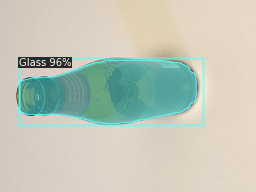

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

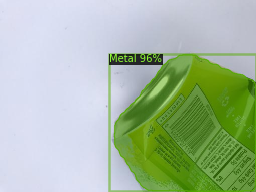

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/plastic/test/plastic433.jpg", metadata, instance_mode=False)

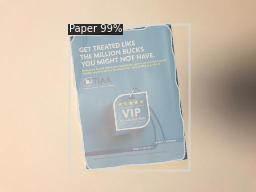

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/paper/test/paper584.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/test/"
random_test_sample(test_dataset_path, 10, metadata)

### Train7

In [ ]:
dataset_name = "glassAndMetalAndPlasticAndPaper400"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
cfg, test_result = train(dataset_name, 
                         images_per_batch=2, 
                         learning_rate=0.00025, 
                         iteration=3000, 
                         batch_size_per_image=128, 
                         num_classes=4, 
                         test=True, 
                         test_dataset_name=val_dataset_name)

In [ ]:
# !cp /content/output/model_final.pth /content/drive/MyDrive/Detectron/glassMetalPapperPlastic400/model_final.pth

### Evaluate7

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

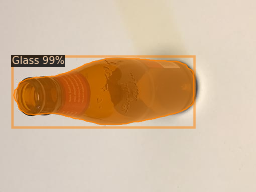

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/glass/test/glass460.jpg", metadata, instance_mode=False)

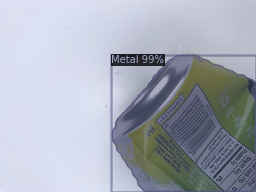

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/metal/test/metal400.jpg", metadata, instance_mode=False)

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/plastic/test/plastic433.jpg", metadata, instance_mode=False)

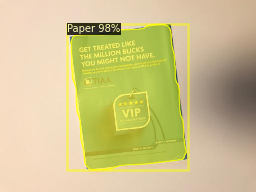

In [ ]:
evaluate("/content/drive/MyDrive/Detectron/data/dataset-resized/paper/test/paper584.jpg", metadata, instance_mode=False)

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Detectron/data/dataset-resized/test/"
random_test_sample(test_dataset_path, 10, metadata)

## Automation of training, parameter setting

### Detection

In [ ]:
dataset_name = "glassAndMetalAndPlasticAndPaper400"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
val_dataset_name = "valid20"
val_metadata = {}
val_json_file = "/content/drive/MyDrive/Detectron/data/valid20/result.json"
val_image_root = "/content/drive/MyDrive/Detectron/data/valid20"

register_coco_instances(val_dataset_name, val_metadata, val_json_file, val_image_root)
val_metadata = MetadataCatalog.get(val_dataset_name)
val_dataset_dicts = DatasetCatalog.get(val_dataset_name)

In [ ]:
images_per_batch = [2, 4, 8, 16, 32, 64]
learning_rate = [0.01, 0.0025, 0.001, 0.00025, 0.0001, 0.000025, 0.00001]
batch_size_per_image = [128, 256, 512] 
iteration = 5000
num_classes = 4

#### COCO-pretrained R50-FPN Faster R-CNN

In [ ]:
init_model="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [ ]:
result = []
for ipb in images_per_batch:
    for lr in learning_rate:
        for bspi in batch_size_per_image:
            cfg, test_result = train(dataset_name, 
                                     images_per_batch=ipb, 
                                     learning_rate=lr, 
                                     iteration=iteration, 
                                     batch_size_per_image=bspi, 
                                     num_classes=num_classes, 
                                     test=True, 
                                     test_dataset_name=val_dataset_name,
                                     init_model=init_model)

            result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
df = pd.DataFrame()
for i in range(len(result)):
    temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
    temp = temp.T

    images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
    learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
    batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

    temp['images_per_batch'] = images_per_batch.values
    temp['learning_rate'] = learning_rate.values
    temp['batch_size_per_image'] = batch_size_per_image.values

    df = pd.concat([df, temp])

In [ ]:
df

In [ ]:
df.to_csv('result/R50-FPN_Faster_R-CNN.csv', index=True, index_label="Result-type") 

#### COCO-pretrained R101-FPN Faster R-CNN

In [ ]:
init_model="COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

In [ ]:
result = []
for ipb in images_per_batch:
    for lr in learning_rate:
        for bspi in batch_size_per_image:
            cfg, test_result = train(dataset_name, 
                                     images_per_batch=ipb, 
                                     learning_rate=lr, 
                                     iteration=iteration, 
                                     batch_size_per_image=bspi, 
                                     num_classes=num_classes, 
                                     test=True, 
                                     test_dataset_name=val_dataset_name,
                                     init_model=init_model)

            result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
df = pd.DataFrame()
for i in range(len(result)):
    temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
    temp = temp.T

    images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
    learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
    batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

    temp['images_per_batch'] = images_per_batch.values
    temp['learning_rate'] = learning_rate.values
    temp['batch_size_per_image'] = batch_size_per_image.values

    df = pd.concat([df, temp])

In [ ]:
df

In [ ]:
df.to_csv('result/R101-FPN_Faster_R-CNN.csv', index=True, index_label="Result-type") 

#### COCO-pretrained R50-FPN RetinaNet

In [ ]:
init_model="COCO-Detection/retinanet_R_50_FPN_3x.yaml"

In [ ]:
result = []
for ipb in images_per_batch:
    for lr in learning_rate:
        for bspi in batch_size_per_image:
            cfg, test_result = train(dataset_name, 
                                     images_per_batch=ipb, 
                                     learning_rate=lr, 
                                     iteration=iteration, 
                                     batch_size_per_image=bspi, 
                                     num_classes=num_classes, 
                                     test=True, 
                                     test_dataset_name=val_dataset_name,
                                     init_model=init_model)

            result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
df = pd.DataFrame()
for i in range(len(result)):
    temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
    temp = temp.T

    images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
    learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
    batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

    temp['images_per_batch'] = images_per_batch.values
    temp['learning_rate'] = learning_rate.values
    temp['batch_size_per_image'] = batch_size_per_image.values

    df = pd.concat([df, temp])

In [ ]:
df

In [ ]:
df.to_csv('result/R50-FPN_RetinaNet.csv', index=True, index_label="Result-type") 

#### COCO-pretrained R101-FPN RetinaNet

In [ ]:
init_model="COCO-Detection/retinanet_R_101_FPN_3x.yaml"

In [ ]:
result = []
for ipb in images_per_batch:
    for lr in learning_rate:
        for bspi in batch_size_per_image:
            cfg, test_result = train(dataset_name, 
                                     images_per_batch=ipb, 
                                     learning_rate=lr, 
                                     iteration=iteration, 
                                     batch_size_per_image=bspi, 
                                     num_classes=num_classes, 
                                     test=True, 
                                     test_dataset_name=val_dataset_name,
                                     init_model=init_model)

            result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
df = pd.DataFrame()
for i in range(len(result)):
    temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
    temp = temp.T

    images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
    learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
    batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

    temp['images_per_batch'] = images_per_batch.values
    temp['learning_rate'] = learning_rate.values
    temp['batch_size_per_image'] = batch_size_per_image.values

    df = pd.concat([df, temp])

In [ ]:
df

In [ ]:
df.to_csv('result/R101-FPN_RetinaNet.csv', index=True, index_label="Result-type") 

### Instance Segmentation

#### COCO-pretrained R50-FPN Mask R-CNN

In [ ]:
init_model="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

In [ ]:
# register_coco_instances(dataset_name, metadata, json_file, image_root)
# metadata = MetadataCatalog.get(dataset_name)
# dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
# register_coco_instances(val_dataset_name, val_metadata, val_json_file, val_image_root)
# val_metadata = MetadataCatalog.get(val_dataset_name)
# val_dataset_dicts = DatasetCatalog.get(val_dataset_name)

In [ ]:
dataset_name = "glassAndMetalAndPlasticAndPaper400"
metadata = {}
json_file = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400/result.json"
image_root = "/content/drive/MyDrive/Detectron/data/glassMetalPaperPlastic400"

register_coco_instances(dataset_name, metadata, json_file, image_root)
metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

In [ ]:
# images_per_batch = [2, 4, 8, 16, 32, 64]
# learning_rate = [0.01, 0.0025, 0.001, 0.00025, 0.0001, 0.000025, 0.00001]
# batch_size_per_image = [128, 256, 512] 
# iteration = 300
# num_classes = 4

In [ ]:
images_per_batch = [2]
learning_rate = [0.01]
batch_size_per_image = [128] 
iteration = 300
num_classes = 4

In [ ]:
result = []
for ipb in images_per_batch:
    for lr in learning_rate:
        for bspi in batch_size_per_image:
            cfg, test_result = train(dataset_name, 
                                     images_per_batch=ipb, 
                                     learning_rate=lr, 
                                     iteration=iteration, 
                                     batch_size_per_image=bspi, 
                                     num_classes=num_classes, 
                                     test=True, 
                                     test_dataset_name=val_dataset_name,
                                     init_model=init_model)

            result.append([ipb, lr, bspi, cfg, test_result])

In [ ]:
df = pd.DataFrame()
for i in range(len(result)):
    temp = pd.DataFrame(result[i][4], columns=result[i][4].keys())
    temp = temp.T

    images_per_batch = pd.Series([result[i][0], result[i][0]], index=[0, 1])
    learning_rate = pd.Series([result[i][1], result[i][1]], index=[0, 1])
    batch_size_per_image = pd.Series([result[i][2], result[i][2]], index=[0, 1])

    temp['images_per_batch'] = images_per_batch.values
    temp['learning_rate'] = learning_rate.values
    temp['batch_size_per_image'] = batch_size_per_image.values

    df = pd.concat([df, temp])

In [ ]:
df

In [ ]:
df.to_csv('out.csv', index=True, index_label="Result-type") 

In [ ]:
df2 = pd.read_csv('result/out.csv')

In [ ]:
def get_best_result(df, number=3):
    dfbbox = df.loc[df['Result-type'] == "bbox"].sort_values(by='AP', ascending=False).head(number)
    dfsegm = df.loc[df['Result-type'] == "segm"].sort_values(by='AP', ascending=False).head(number)
    return dfbbox, dfsegm

In [ ]:
dfbbox, dfsegm = get_best_result(df2)

In [ ]:
dfbbox

In [ ]:
dfsegm